<a href="https://colab.research.google.com/github/w0726/ceshi/blob/master/0814.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls -l 'drive/My Drive/mycode/dataset'

total 2417810
drwx------ 2 root root       4096 Aug  6 12:03 10classes
-rw------- 1 root root 2475828275 Aug  5 15:23 10classes.zip
drwx------ 2 root root       4096 Aug 14 02:36 2classes


In [ ]:
# !unzip 'drive/My Drive/mycode/dataset/10classes.zip' -d 'drive/My Drive/mycode/dataset'
# !ls -l 'drive/My Drive/mycode/dataset/10classes'

In [ ]:
import os
print(len(os.listdir('drive/My Drive/mycode/dataset/2classes')))
!pwd

259
/content


In [10]:
import os
import tqdm
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score
import pickle


# ------------------- label conversion tools ------------------ #


def labels2cat(label_encoder, list):
    return label_encoder.transform(list)


def labels2onehot(onehotEncoder, label_encoder, list):
    return onehotEncoder.transform(label_encoder.transform(list).reshape(-1, 1)).toarray()


def onehot2labels(label_encoder, y_onehot):
    return label_encoder.inverse_transform(np.where(y_onehot == 1)[1]).tolist()


def cat2labels(label_encoder, y_cat):
    return label_encoder.inverse_transform(y_cat).tolist()


def cat2onehot(action_names: list):
    # convert labels -> category
    le = LabelEncoder()
    le.fit(action_names)

    # # show how many classes there are
    # list(le.classes_)

    # convert category -> 1-hot
    action_category = le.transform(action_names).reshape(-1, 1)
    enc = OneHotEncoder()
    enc.fit(action_category)


def getnames(data_path, action_name_path):
    # load UCF101 actions names
    with open(action_name_path, 'rb') as f:
        action_names = pickle.load(f)   # load UCF101 actions names

    # convert labels -> category
    le = LabelEncoder()
    le.fit(action_names)

    # # show how many classes there are
    # list(le.classes_)

    # convert category -> 1-hot
    action_category = le.transform(action_names).reshape(-1, 1)     # type: numpy.ndarray
    enc = OneHotEncoder()
    enc.fit(action_category)

    # # example
    # y = ['HorseRace', 'YoYo', 'WalkingWithDog']
    # y_onehot = labels2onehot(enc, le, y)
    # y2 = onehot2labels(le, y_onehot)

    actions = []
    fnames = os.listdir(data_path)

    all_names = []
    for f in fnames:
        loc1 = f.find('v_')
        loc2 = f.find('_g')
        actions.append(f[(loc1 + 2): loc2])

        all_names.append(f)

    # list all data files
    all_folders_list = all_names              # all video file names
    all_labels_list = labels2cat(le, actions)    # all video labels, type: int

    return all_folders_list, all_labels_list


# ------------------------ 3D CNN module ---------------------- #


def conv3D_output_size(img_size, padding, kernel_size, stride):
    # compute output shape of conv3D
    outshape = (np.floor((img_size[0] + 2 * padding[0] - (kernel_size[0] - 1) - 1) / stride[0] + 1).astype(int),
                np.floor((img_size[1] + 2 * padding[1] - (kernel_size[1] - 1) - 1) / stride[1] + 1).astype(int),
                np.floor((img_size[2] + 2 * padding[2] - (kernel_size[2] - 1) - 1) / stride[2] + 1).astype(int))
    return outshape


class CNN3D(nn.Module):
    def __init__(self, t_dim=120, img_x=90, img_y=120, drop_p=0.2, fc_hidden1=256, fc_hidden2=128, num_classes=50):
        super(CNN3D, self).__init__()

        # set video dimension
        self.t_dim = t_dim
        self.img_x = img_x
        self.img_y = img_y
        # fully connected layer hidden nodes
        self.fc_hidden1, self.fc_hidden2 = fc_hidden1, fc_hidden2
        self.drop_p = drop_p
        self.num_classes = num_classes
        self.ch1, self.ch2 = 32, 48
        self.k1, self.k2 = (5, 5, 5), (3, 3, 3)  # 3d kernel size
        self.s1, self.s2 = (2, 2, 2), (2, 2, 2)  # 3d strides
        self.pd1, self.pd2 = (0, 0, 0), (0, 0, 0)  # 3d padding

        # compute conv1 & conv2 output shape
        self.conv1_outshape = conv3D_output_size((self.t_dim, self.img_x, self.img_y), self.pd1, self.k1, self.s1)
        self.conv2_outshape = conv3D_output_size(self.conv1_outshape, self.pd2, self.k2, self.s2)

        self.conv1 = nn.Conv3d(in_channels=1, out_channels=self.ch1, kernel_size=self.k1, stride=self.s1,
                               padding=self.pd1)
        self.bn1 = nn.BatchNorm3d(self.ch1)
        self.conv2 = nn.Conv3d(in_channels=self.ch1, out_channels=self.ch2, kernel_size=self.k2, stride=self.s2,
                               padding=self.pd2)
        self.bn2 = nn.BatchNorm3d(self.ch2)
        self.relu = nn.ReLU(inplace=True)
        self.drop = nn.Dropout3d(self.drop_p)
        self.pool = nn.MaxPool3d(2)
        self.fc1 = nn.Linear(self.ch2 * self.conv2_outshape[0] * self.conv2_outshape[1] * self.conv2_outshape[2],
                             self.fc_hidden1)  # fully connected hidden layer
        self.fc2 = nn.Linear(self.fc_hidden1, self.fc_hidden2)
        self.fc3 = nn.Linear(self.fc_hidden2, self.num_classes)  # fully connected layer, output = multi-classes

    def forward(self, x_3d):
        # Conv 1
        x = self.conv1(x_3d)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.drop(x)
        # Conv 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.drop(x)
        # FC 1 and 2
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=self.drop_p, training=self.training)
        x = self.fc3(x)

        return x


# ---------------------- Dataloaders ---------------------- #
# for 3DCNN
class Dataset_3DCNN(data.Dataset):
    """Characterizes a dataset for PyTorch"""

    '''
        data_path: the root dir of vedios
        folders: all vedio file names in the dataset, a folder contains a vedio devided by frame
        labels: all labels of the vedio in the dataset
        frames: numpy.ndarray, contains the indexes of frames to be trained in each vedio
        transform: torchvision.transforms
    '''

    def __init__(self, data_path, folders, labels, frames, transform=None):
        "Initialization"
        self.data_path = data_path
        self.labels = labels
        self.folders = folders
        self.transform = transform
        self.frames = frames

    def __len__(self):
        "Denotes the total number of samples"
        return len(self.folders)

    def read_images(self, data_path, folder, use_transform):
        """
            path: the root dir of selected_folder, the same as self.data_path
        """
        X = []
        for i in self.frames:
            image = Image.open(os.path.join(data_path, folder, 'frame{:06d}.jpg'.format(i))).convert('L')

            if use_transform is not None:
                image = use_transform(image)

            X.append(image.squeeze_(0))  # 灰度图像， 1通道，dim=0的元素个数为1时，删去该维度
        X = torch.stack(X, dim=0)   # 增加新维度，在0维上堆叠

        return X

    def __getitem__(self, idx):
        "Generates one sample of data"
        # Select sample
        folder = self.folders[idx]

        # Load data
        data = self.read_images(self.data_path, folder, self.transform).unsqueeze_(0)  # (input) spatial images
        targets = torch.LongTensor([self.labels[idx]])                             # (target) LongTensor are for int64 instead of FloatTensor

        # print(data.shape)
        return data, targets


# ---------------------- Train for 3DCNN ---------------------- #
def train(log_interval, model, device, train_loader, optimizer, epoch):
    start = time.time()
    print(f'{time.asctime(time.localtime(start))}')
    # set model as training mode
    model.train()

    losses = []
    scores = []
    N_count = 0   # counting total trained sample in one epoch
    for batch_idx, (X, y) in enumerate(train_loader):
        # distribute data to device
        X, y = X.to(device), y.to(device).view(-1, )
        # print(X.size(), y)

        N_count += X.size(0)

        optimizer.zero_grad()
        output = model(X)  # output size = (batch, number of classes)

        loss = F.cross_entropy(output, y)
        losses.append(loss.item())

        # to compute accuracy
        y_pred = torch.max(output, 1)[1]  # y_pred != output
        # print(f'y_pred:\n{y_pred}\ny:\n{y}')
        step_score = accuracy_score(y.cpu().data.squeeze().numpy(), y_pred.cpu().data.squeeze().numpy())
        scores.append(step_score)         # computed on CPU

        loss.backward()
        optimizer.step()

        # show information
        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accu: {:.2f}%'.format(
                epoch + 1, N_count, len(train_loader.dataset), 100. * (batch_idx + 1) / len(train_loader), loss.item(), 100 * step_score))
    print(f'[{time.time()-start}s]\tTrain Epoch {epoch+1} is done.')
    return losses, scores


# ---------------------- Validation for 3DCNN ---------------------- #
def validation(model, device, optimizer, test_loader, epoch, save_model_path, last_val_loss, last_val_score):
    print(f'{time.ctime()}')
    # set model as testing mode
    model.eval()

    test_loss = 0
    all_y = []
    all_y_pred = []
    with torch.no_grad():
        for X, y in test_loader:
            # distribute data to device
            X, y = X.to(device), y.to(device).view(-1, )

            output = model(X)

            loss = F.cross_entropy(output, y, reduction='sum')
            test_loss += loss.item()                 # sum up batch loss
            y_pred = output.max(1, keepdim=True)[1]  # (y_pred != output) get the index of the max log-probability

            # collect all y and y_pred in all batches
            all_y.extend(y)
            all_y_pred.extend(y_pred)

    test_loss /= len(test_loader.dataset)

    # to compute accuracy
    all_y = torch.stack(all_y, dim=0)
    all_y_pred = torch.stack(all_y_pred, dim=0)
    test_score = accuracy_score(all_y.cpu().data.squeeze().numpy(), all_y_pred.cpu().data.squeeze().numpy())

    # show information
    print('\nTest set ({:d} samples): Average loss: {:.4f}, Accuracy: {:.2f}%\n'.format(len(all_y), test_loss, 100 * test_score))

    # save Pytorch models of best record
    if test_loss < last_val_loss or test_score > last_val_score:
      torch.save(model.state_dict(), os.path.join(save_model_path, '3dcnn_epoch{}.pth'.format(epoch + 1)))  # save spatial_encoder
      torch.save(optimizer.state_dict(), os.path.join(save_model_path, '3dcnn_optimizer_epoch{}.pth'.format(epoch + 1)))      # save optimizer
      print(f"Epoch {epoch+1} model saved!\n")

    return test_loss, test_score


# -------------------- (reload) model prediction ---------------------- #
def Conv3d_final_prediction(model, device, loader):
    model.eval()

    all_y_pred = []
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(tqdm(loader)):
            # distribute data to device
            X = X.to(device)
            output = model(X)
            y_pred = output.max(1, keepdim=True)[1]  # location of max log-probability as prediction
            all_y_pred.extend(y_pred.cpu().data.squeeze().numpy().tolist())

    return all_y_pred


# -------------------- DRAW PLOT ---------------------- #

def draw(epoch_size: int, epoch_train_losses: np.ndarray, epoch_train_scores: np.ndarray, epoch_test_losses: np.ndarray, epoch_test_scores: np.ndarray):
    # plot
    fig = plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.plot(np.arange(1, epoch_size + 1), epoch_train_losses[:, -1])  # train loss (on epoch end)
    plt.plot(np.arange(1, epoch_size + 1), epoch_test_losses)  # test loss (on epoch end)
    plt.title("model loss")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend(['train', 'test'], loc="upper left")
    # 2nd figure
    plt.subplot(122)
    plt.plot(np.arange(1, epoch_size + 1), epoch_train_scores[:, -1])  # train accuracy (on epoch end)
    plt.plot(np.arange(1, epoch_size + 1), epoch_test_scores)  # test accuracy (on epoch end)
    # plt.plot(histories.losses_val)
    plt.title("training scores")
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend(['train', 'test'], loc="upper left")
    title = "./fig_UCF101_3DCNN.png"
    # plt.savefig(title, dpi=600)
    # plt.close(fig)
    plt.show()


def main():

    # set path
    data_path = "drive/My Drive/mycode/dataset/2classes"    # define UCF-101 spatial data path
    action_name_path = "drive/My Drive/mycode/classes.pkl"  # load preprocessed action names
    save_model_path = "drive/My Drive/mycode/Conv3D_ckpt/"  # save Pytorch models

    # Detect devices
    use_cuda = torch.cuda.is_available()                   # check if GPU exists
    device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU

    # load UCF101 actions names
    all_folders_list, all_labels_list = getnames(data_path, action_name_path)

    # train, test split
    train_list, test_list, train_label, test_label = train_test_split(all_folders_list, all_labels_list, test_size=0.25, random_state=42)

    # image transformation
    img_x, img_y = 256, 342  # resize video 2d frame size
    transform = transforms.Compose([transforms.Resize([img_x, img_y]),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5], std=[0.5])])

    # Get datasat and dataloader
    begin_frame, end_frame, skip_frame = 1, 10, 1   # Select which frame to begin & end in videos
    selected_frames = np.arange(begin_frame, end_frame, skip_frame).tolist()
    train_set = Dataset_3DCNN(data_path, train_list, train_label, selected_frames, transform=transform)
    valid_set = Dataset_3DCNN(data_path, test_list, test_label, selected_frames, transform=transform)

    batch_size = 5
    params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 4, 'pin_memory': True} if use_cuda else {'batch_size': batch_size, 'shuffle': True}
    train_loader = data.DataLoader(train_set, **params)
    valid_loader = data.DataLoader(valid_set, **params)

    # create model
    # 3D CNN parameters
    num_classes = 2            # number of target category
    fc_hidden1, fc_hidden2 = 256, 256
    dropout = 0.0        # dropout probability

    cnn3d = CNN3D(t_dim=len(selected_frames),   # 时间维度
                  img_x=img_x,
                  img_y=img_y,
                  drop_p=dropout,
                  fc_hidden1=fc_hidden1,
                  fc_hidden2=fc_hidden2,
                  num_classes=num_classes).to(device)

    # Parallelize model to multiple GPUs
    if torch.cuda.device_count() > 1:
        print("Using", torch.cuda.device_count(), "GPUs!")
        cnn3d = nn.DataParallel(cnn3d)

    # 训练及验证
    # training parameters
    epoch_size = 5
    learning_rate = 1e-4
    log_interval = 2

    optimizer = torch.optim.Adam(cnn3d.parameters(), lr=learning_rate)   # optimize all cnn parameters

    # record training process
    epoch_train_losses = []
    epoch_train_scores = []
    epoch_test_losses = []
    epoch_test_scores = []

    print(f'Epoch size: {epoch_size}\tBatch size: {batch_size}\tLearning rate: {learning_rate}')
    last_val_loss, last_val_score = 0, 0
    for epoch in range(epoch_size):
        # train, test model
        train_losses, train_scores = train(log_interval, cnn3d, device, train_loader, optimizer, epoch)
        epoch_test_loss, epoch_test_score = validation(cnn3d, device, optimizer, valid_loader, epoch, save_model_path, last_val_loss, last_val_score)
        last_val_loss = epoch_test_loss
        last_val_score = epoch_test_score

        # save results
        epoch_train_losses.append(train_losses)
        epoch_train_scores.append(train_scores)
        epoch_test_losses.append(epoch_test_loss)
        epoch_test_scores.append(epoch_test_score)

        # save all train test results
        A = np.array(epoch_train_losses)
        B = np.array(epoch_train_scores)
        C = np.array(epoch_test_losses)
        D = np.array(epoch_test_scores)
        np.save('./3DCNN_epoch_training_losses.npy', A)
        np.save('./3DCNN_epoch_training_scores.npy', B)
        np.save('./3DCNN_epoch_test_loss.npy', C)
        np.save('./3DCNN_epoch_test_score.npy', D)

    # 作图
    return epoch_size, A, B, C, D
    # draw(epoch_size, A, B, C, D)



In [11]:
epoch_size, A, B, C, D = main()

Epoch size: 5	Batch size: 5	Learning rate: 0.0001
Fri Aug 14 05:33:40 2020
Train Epoch: 1 [10/194 (5%)]	Loss: 1.994395, Accu: 40.00%
Train Epoch: 1 [20/194 (10%)]	Loss: 0.866395, Accu: 40.00%
Train Epoch: 1 [30/194 (15%)]	Loss: 2.266103, Accu: 40.00%
Train Epoch: 1 [40/194 (21%)]	Loss: 0.582366, Accu: 80.00%
Train Epoch: 1 [50/194 (26%)]	Loss: 0.593355, Accu: 80.00%
Train Epoch: 1 [60/194 (31%)]	Loss: 2.410541, Accu: 0.00%
Train Epoch: 1 [70/194 (36%)]	Loss: 0.480117, Accu: 80.00%
Train Epoch: 1 [80/194 (41%)]	Loss: 0.781112, Accu: 60.00%
Train Epoch: 1 [90/194 (46%)]	Loss: 0.763960, Accu: 80.00%
Train Epoch: 1 [100/194 (51%)]	Loss: 0.388168, Accu: 80.00%
Train Epoch: 1 [110/194 (56%)]	Loss: 0.618663, Accu: 80.00%
Train Epoch: 1 [120/194 (62%)]	Loss: 0.240954, Accu: 80.00%
Train Epoch: 1 [130/194 (67%)]	Loss: 0.398494, Accu: 80.00%
Train Epoch: 1 [140/194 (72%)]	Loss: 0.259341, Accu: 100.00%
Train Epoch: 1 [150/194 (77%)]	Loss: 0.669110, Accu: 60.00%
Train Epoch: 1 [160/194 (82%)]	Loss

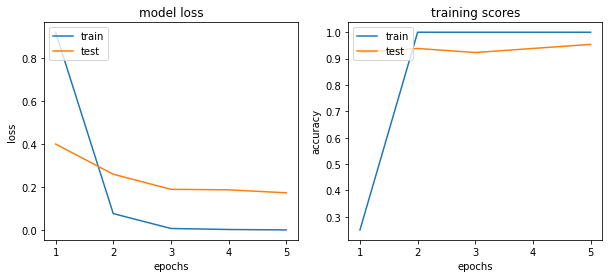

In [12]:
draw(epoch_size, A, B, C, D)

In [ ]:
# cnn3d = CNN3D(t_dim=28,
#         img_x=256, 
#         img_y=342,
#         drop_p=0,
#         fc_hidden1=256,
#         fc_hidden2=256,
#         num_classes=10)
# torch.save(cnn3d, 'drive/My Drive/mycode/cnn3d.pth')

In [ ]:
# !pip install tensorwatch
# import tensorwatch as tw
# import torchvision
# import torch
# alexnet_model = torchvision.models.alexnet().to(torch.device('cuda'))
# tw.draw_model(alexnet_model, [1, 3, 224, 224])

In [ ]:
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter()
# writer.add_graph(cnn3d, input_to_model=torch.zeros([1, 1, 28, 256, 342]), verbose=False)